# Transfer Learning


There are two main Transfer Learning schemes:
- __Pre-trained Convolutional layers as fixed feature extractor__
- __Fine-tuning on pre-trained Convolutional layers__
    - load pretrained weights from a model trained on another dataset;
    - re-initialize the top fc layers with fresh weights;
    - train models on new dataset while freezing conv layers;

<img src="images/transfer_learning_2.jpeg" width="400">

<img src="images/transfer_learning_1.jpg" width="400">
### Pre-trained Convolutional layers as fixed feature extractor


Convolutional layers have __fixed weights__ and therefore are not trained. They are __used to extract features and construct a rich vector embedding for every image__. Once these embeddings have been computed for all images, they become the new inputs and can be used to train a linear classifier or a fully connected network for the new dataset.

In [8]:
import tensorflow as tf
import numpy as np
import glob
from scipy import misc 
import matplotlib.pyplot as plt
%matplotlib inline

tf_keras = tf.contrib.keras





# Feature Extraction

## Load a pre-trained VGG Network on ImageNets

In [9]:
# load pre-trained VGG model
model = tf_keras.applications.VGG19(weights='imagenet',
                                    input_shape = (224, 224, 3))

In [10]:
def make_prediction(img_path):
    
    # Load and resize image
    img = tf_keras.preprocessing.image.load_img(img_path,
                                                target_size=(224, 224))
    
    x = tf_keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0) # 4D tensor transformation
    
    # normalize/preprocess image
    x = tf_keras.applications.vgg19.preprocess_input(x)

    preds = model.predict(x)
    
    # decode the results into a list of tuples
    #(class, description, probability)
    result = tf_keras.applications.vgg19.decode_predictions(
        preds, top=5)[0]

    print("Predictions:\n")
    for idx, (_, name, prob) in enumerate(result):
        print("{}.".format(idx+1))
        print("Name: {}".format(name))
        print("Probability: {}\n".format(prob))

In [11]:
def plot_image(img_path):
    # figure size
    fig = plt.figure(figsize=(8, 8))
    
    # load images
    image = tf_keras.preprocessing.image.load_img(img_path)
    img_array = tf_keras.preprocessing.image.img_to_array(image)
    print("Image size: {}".format(img_array.shape))
    
    # plot image
    plt.imshow(image)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

Image size: (499, 495, 3)


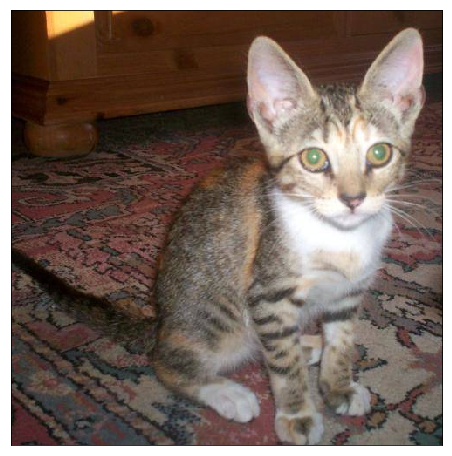

In [12]:
cat_path = "data/training/cat/cat.7.jpg"
plot_image(cat_path)

# Make Predictions

In [13]:
make_prediction(cat_path)

Predictions:

1.
Name: Egyptian_cat
Probability: 0.7617394328117371

2.
Name: tabby
Probability: 0.1243278980255127

3.
Name: tiger_cat
Probability: 0.07113085687160492

4.
Name: lynx
Probability: 0.007362822536379099

5.
Name: doormat
Probability: 0.005624132230877876



Image size: (500, 368, 3)


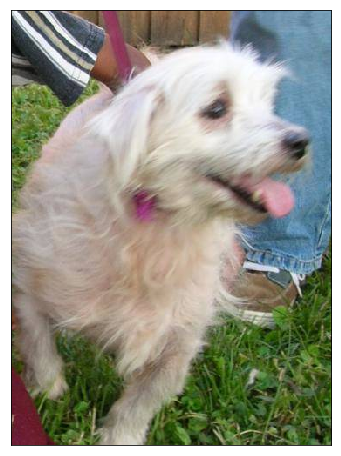

In [14]:
dog_path = "data/training/dog/dog.9.jpg"
plot_image(dog_path)

In [15]:
make_prediction(dog_path)

Predictions:

1.
Name: Maltese_dog
Probability: 0.21355079114437103

2.
Name: West_Highland_white_terrier
Probability: 0.1704513430595398

3.
Name: Norfolk_terrier
Probability: 0.13558588922023773

4.
Name: cairn
Probability: 0.07530666887760162

5.
Name: wire-haired_fox_terrier
Probability: 0.05178091675043106



In [16]:
train_data_dir = "data/training"
test_data_dir = "data/testing"
# 25000 images
train_size = 20000
test_size = 5000
input_shape = (150, 150, 3)
batch_size = 32

# Load Pre-trained VGG16 Model 

In [17]:
# load pre-trained VGG model and exclude top dense layers
model = tf_keras.applications.VGG16(include_top=False,
                                    weights='imagenet')

# Load Images to Tensor

In [18]:
def load_data_array(img_files):
    img_size = (150, 150, 3)
    images = []
    for img in img_files:
        try:
            image_ar = misc.imresize(misc.imread(img), img_size)
            if np.asarray(image_ar).shape == img_size:
                images.append(image_ar)
        except:
            print("ERROR: {}".format(img))
            continue

    images = np.asarray(images)
    return images

In [19]:
path_d = glob.glob("data/training/cat/*.jpg")
train_cat = load_data_array(path_d)

In [20]:
path_d = glob.glob("data/training/dog/*.jpg")
train_dog = load_data_array(path_d)

In [21]:
path_d = glob.glob("data/testing/cat/*.jpg")
test_cat = load_data_array(path_d)

In [22]:
path_d = glob.glob("data/testing/dog/*.jpg")
test_dog = load_data_array(path_d)

# Feature Extracting Function

In [23]:
def extract_vgg_features(model, images, data_name):
    
    extracted_features = model.predict(images)
    
    file_name = "extracted_features_{}.npy".format(data_name)
    np.save(open(file_name, 'wb'), extracted_features)

In [24]:
# GPU recommended
extract_vgg_features(model, train_cat, data_name = 'train_cat')
extract_vgg_features(model, train_dog, data_name = 'train_dog')

In [25]:
# GPU recommanded
extract_vgg_features(model, test_cat, data_name = 'test_cat')
extract_vgg_features(model, test_dog, data_name = 'test_dog')

# Load Generated Features And Reconstruct Label Vectors

In [26]:
train_data_cat = np.load(open('extracted_features_train_cat.npy', 'rb'))
train_data_dog = np.load(open('extracted_features_train_dog.npy', 'rb'))
train_data = np.vstack((train_data_cat, train_data_dog))


train_labels = np.array([0] * train_data_cat.shape[0]  +
                        [1] * train_data_dog.shape[0])

print("Train data size: {}".format(train_data.shape))
print("Train label size: {}".format(train_labels.shape))

Train data size: (20000, 4, 4, 512)
Train label size: (20000,)


In [27]:
test_data_cat = np.load(open('extracted_features_test_cat.npy', 'rb'))
test_data_dog = np.load(open('extracted_features_test_dog.npy', 'rb'))
test_data = np.vstack((test_data_cat, test_data_dog))

test_labels = np.array([0] * test_data_cat.shape[0]  +
                       [1] * test_data_dog.shape[0])
print("Train size: {}".format(test_data.shape))

Train size: (5000, 4, 4, 512)


# Define a Simple Fully Connected Model

In [28]:
def DNN_Classifier():
    inputs = tf_keras.layers.Input(shape = (4, 4, 512))
    net = tf_keras.layers.Flatten()(inputs)
    net = tf_keras.layers.Dense(256, activation=tf.nn.relu)(net)
    net = tf_keras.layers.Dropout(0.6)(net)
    outputs = tf_keras.layers.Dense(1, activation=tf.nn.sigmoid)(net)
    model = tf_keras.models.Model(inputs=inputs, outputs=outputs)
    return model

def compile_model(model):
    optimizer = tf_keras.optimizers.RMSprop(lr=0.0001)
    model.compile(loss = tf_keras.losses.binary_crossentropy,
                  optimizer = optimizer,
                  metrics = [tf_keras.metrics.binary_accuracy])
    print(model.summary())
    return model

In [35]:
model = DNN_Classifier()
model = compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________
None


# Training

In [36]:
history = model.fit(x=train_data,
                    y=train_labels,
                    batch_size=32,
                    verbose=2, 
                    epochs=20, 
                    validation_data=(test_data,test_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
3s - loss: 1.1674 - binary_accuracy: 0.8962 - val_loss: 0.6748 - val_binary_accuracy: 0.9378
Epoch 2/20
2s - loss: 0.6328 - binary_accuracy: 0.9375 - val_loss: 0.4840 - val_binary_accuracy: 0.9464
Epoch 3/20
2s - loss: 0.4099 - binary_accuracy: 0.9529 - val_loss: 0.4453 - val_binary_accuracy: 0.9450
Epoch 4/20
2s - loss: 0.3040 - binary_accuracy: 0.9620 - val_loss: 0.3996 - val_binary_accuracy: 0.9476
Epoch 5/20
2s - loss: 0.2367 - binary_accuracy: 0.9693 - val_loss: 0.3910 - val_binary_accuracy: 0.9474
Epoch 6/20
2s - loss: 0.1769 - binary_accuracy: 0.9742 - val_loss: 0.4009 - val_binary_accuracy: 0.9506
Epoch 7/20
2s - loss: 0.1556 - binary_accuracy: 0.9787 - val_loss: 0.4122 - val_binary_accuracy: 0.9480
Epoch 8/20
2s - loss: 0.1394 - binary_accuracy: 0.9819 - val_loss: 0.4127 - val_binary_accuracy: 0.9510
Epoch 9/20
2s - loss: 0.1149 - binary_accuracy: 0.9855 - val_loss: 0.4573 - val_binary_accuracy: 0.9496
Epoch 10/20
2s 

# Evaluating

In [37]:
model.evaluate(test_data,test_labels, batch_size=32, verbose=1)

4640/5000 [==========================>...] - ETA: 0s

[0.48574579272480067, 0.9496]

In [38]:
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('vgg accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('vgg loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.show()

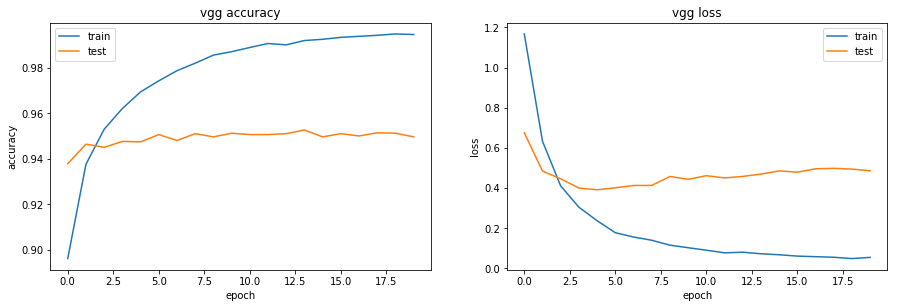

In [39]:
plot_accuracy_and_loss(history)

In [40]:
#save model
model_json = model.to_json()
open('cat_and_dog_model.json', 'w').write(model_json)
model.save_weights('image_classifier_cat_and_dog.h5', overwrite=True)

### TensorFlow provide pre-built estimators to construct a multi-layer FC layer.

In [44]:
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
    train_data)

clf = tf.contrib.learn.DNNClassifier(hidden_units = [256],
                                     feature_columns = feature_columns,
                                     n_classes=2,
                                     optimizer=tf.train.RMSPropOptimizer(
                                         learning_rate=0.0001),
                                     activation_fn=tf.nn.relu,
                                     dropout=0.6)

clf.fit(train_data, train_labels,
        steps=5, batch_size=32)

test_pred = clf.predict(test_data, batch_size =32)

#score = tf.metrics.accuracy(test_labels, test_pred)
#print("Accuracy: %f" % score)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_evaluation_master': '', '_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_task_id': 0, '_save_summary_steps': 100, '_model_dir': '/tmp/tmpaz1ydc6w', '_master': '', '_num_worker_replicas': 0, '_task_type': None, '_save_checkpoints_steps': None, '_num_ps_replicas': 0, '_environment': 'local', '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f526c3d37f0>, '_session_config': None, '_tf_random_seed': None}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpaz1ydc6w/model.ckpt.
INFO:tensorflow:loss = 12.2154, step = 1
INFO:tensorflow:Saving checkpoints for 5 into /tmp/tmpaz1ydc6w/model.ckpt.
INFO:tensorflow:Loss for final step: 6.47218.
INFO:tensorflow:Restoring parameters fro

In [49]:
base_model = tf_keras.applications.VGG16(include_top=False,
                                         weights='imagenet',
                                         input_shape=(150, 150, 3))

In [53]:
def fine_tune_VGG(base_model):
    net = base_model.output    
    net = tf_keras.layers.Flatten(
        input_shape=base_model.output_shape[1:])(net)

    net = tf_keras.layers.Dense(256, activation=tf.nn.relu)(net)
    net = tf_keras.layers.Dropout(0.5)(net)
    
    # final Dense layer with binary classification
    outputs = tf_keras.layers.Dense(1, activation=tf.nn.sigmoid)(net)

    # define model with base_model's input
    model = tf_keras.models.Model(inputs=base_model.input, outputs=outputs)
    
    # freeze weights of conv blocks 1-4 (15 layers)
    # fine-tune last conv block and dense layers
    for layer in model.layers[:15]:
        layer.trainable = False
    
    return model

def compile_model(model):
    optimizer = tf_keras.optimizers.SGD(lr=1e-4, momentum=0.9)
    model.compile(loss = tf_keras.losses.binary_crossentropy,
                  optimizer = optimizer,
                  metrics = [tf_keras.metrics.binary_accuracy])

    print(model.summary())
    
    return model

In [54]:
model = fine_tune_VGG(base_model)
model = compile_model(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

# Define Train and Test Data Generators

In [55]:
batch_size = 16

train_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = tf_keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Train and Fine-tune Model

In [56]:
# fine-tune the model
history = model.fit_generator(
        train_generator,
        steps_per_epoch= 5, #train_size // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps= 10) #test_size // batch_size)

Epoch 1/5
5/5 [==============================] - 6s - loss: 0.8922 - binary_accuracy: 0.4000 - val_loss: 0.6807 - val_binary_accuracy: 0.5625
Epoch 2/5
5/5 [==============================] - 2s - loss: 0.7509 - binary_accuracy: 0.4750 - val_loss: 0.7277 - val_binary_accuracy: 0.4875
Epoch 3/5
5/5 [==============================] - 2s - loss: 0.7425 - binary_accuracy: 0.5250 - val_loss: 0.6379 - val_binary_accuracy: 0.6312
Epoch 4/5
5/5 [==============================] - 2s - loss: 0.7946 - binary_accuracy: 0.4250 - val_loss: 0.6323 - val_binary_accuracy: 0.6625
Epoch 5/5
5/5 [==============================] - 3s - loss: 0.7587 - binary_accuracy: 0.5375 - val_loss: 0.6363 - val_binary_accuracy: 0.6750


# Evaluate Trained Model 

In [57]:
loss, acc= model.evaluate_generator(validation_generator, steps = 10)
print("loss: {}".format(loss))
print("accuracy: {}".format(acc))

loss: 0.6164673805236817
accuracy: 0.675


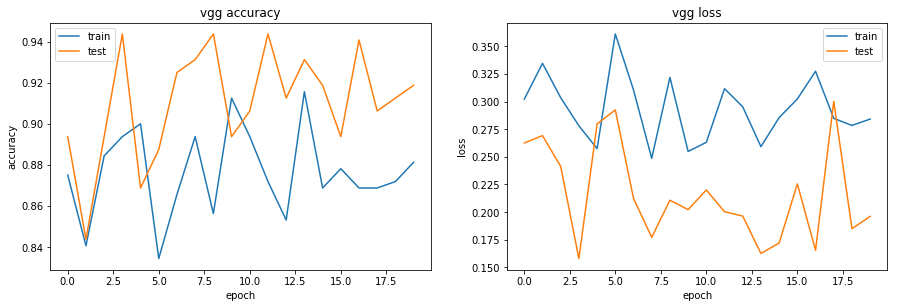

In [21]:
plot_accuracy_and_loss(history)

In [23]:
#save model
model_json = model.to_json()
open('cat_and_dog_fine_tune_model.json', 'w').write(model_json)
model.save_weights('image_classifier_cat_and_dog_fine_tune_.h5',
                   overwrite=True)